In [73]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LSTM
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

module_path = '/Users/zhuo/repos/seq-gan/sgtlstm'
if module_path not in sys.path:
    sys.path.append(module_path)

In [68]:
if 'sgtlstm' in sys.modules:
    importlib.reload(sys.modules['sgtlstm'])

from sgtlstm.utils import load_fixed_length_sequence_from_pickle, create_dataset
from sgtlstm.utils import create_dataset
from sgtlstm.SeqGan import build_G, build_D
from sgtlstm.pretrain import pretrain_generator, pretrain_discriminator, create_self_regression_data_batch
from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

## Global Variables 


In [44]:
BATCH_SIZE = 8
EPOCHS = 100
BUFFER_SIZE = 500

T = 10 + 1
VOCAB = ['END/PADDING', 'INIT', 'start', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 5
HIDDEN_DIM = 32
K_MIST = 7
END_TOKEN = 0
MAX_TIME = 1024

## Load data 

In [45]:
valid_data_path = '/Users/zhuo/repos/seq-gan/data/fixed_length_with_init_token/valid_sequences.pickle'
invalid_data_path = '/Users/zhuo/repos/seq-gan/data/fixed_length_with_init_token/invalid_sequences.pickle'

valid_event_type_seqs, valid_timestamp_seqs = load_fixed_length_sequence_from_pickle(valid_data_path, to_timedelta=True, end_token=0)
invalid_event_type_seqs, invalid_timestamp_seqs = load_fixed_length_sequence_from_pickle(invalid_data_path, to_timedelta=True, end_token=0)

In [46]:

pretrain_G_et = valid_event_type_seqs
pretrain_G_ts = valid_timestamp_seqs
pretrain_G_labels = np.ones((valid_event_type_seqs.shape[0], 1))



pretrain_G_features = (pretrain_G_et, pretrain_G_ts)
N_pretrain_G = pretrain_G_et.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((pretrain_G_features, pretrain_G_labels))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.repeat(EPOCHS)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


## G and D

In [75]:
def build_G(batch_size, T, event_vocab_dim, emb_dim, hidden_dim=11, k_mixt=7, return_sequence=False):
    """
        Build a generator for event type sequence of shape (batch_size, T, input_dim)
        and input event type sequence of shape (batch_size, T, 1)
    :param T: length of the sequence
    :param event_vocab_dim: size of event vocabulary ['na', 'start', 'click', 'install']
    :param emb_dim: dimension of the embedding layer output for event type
    :param hidden_dim: dimension hidden of the time lstm cell
    :param k_mixt: num of gaussian distributions in gaussian mixture model
    :param return_sequence:
    :return:
    """
    # Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, 1), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta')  # input of continuous feature timestamp

    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(None, 1))
    masked_et = mask_layer(i_et)
    masked_ts = mask_layer(i_ts)

    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(masked_et)
    embed0 = Reshape([1, emb_dim])(embed0)
    merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2)

    # TODO: add deep layers to lstm
    # TODO: add activation after layer norm/batch norm
#     merged0 = tf.keras.layers.LayerNormalization()(merged0)
#     merged0 = tf.keras.layers.PReLU()(merged0)

    hm, tm = TimeLSTM1(hidden_dim, activation='selu', name='time_lstm', 
                       stateful=True, return_sequences=False)(merged0)
    time_comb = tf.concat([hm,tm],axis=1)
    time_out = Dense(1+1, activation='linear', name='output')(time_comb)
    time_out = tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                             scale=tf.math.softplus(t[...,1:])), 
        name='Normal')(time_out)

    # predicted prob of next token
    token_prob = Dense(event_vocab_dim, activation='softmax', name='token_prob')(hm)
    model_gen = Model(
        inputs=[i_et, i_ts],
        outputs=[token_prob, time_out])
    return model_gen


G2 = build_G(
    batch_size=BATCH_SIZE,
    T = T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
    k_mixt = K_MIST,
    return_sequence=False,
)


In [92]:
for feature_sample, _ in dataset.take(1):
    for i in range(0, 1):
        curr_state_et = state_et_batch[:, i:i+1, :]
        curr_state_ts = state_ts_batch[:, i:i+1, :]
        target_et = state_et_batch[:, i+1, :]
        target_ts = state_ts_batch[:, i+1, :]

        state_et_batch, state_ts_batch = feature_sample 
        token_prob, timeout_obj = G2([curr_state_et, curr_state_ts])
        print(timeout_obj)
        gaussian_log=timeout_obj.log_prob(target_ts)
        print(target_ts)

        print(gaussian_log)
        gaussian_loss = -tf.reduce_mean(gaussian_log)
        print('gaussian loss:{}'.format(gaussian_loss))
        

tfp.distributions.Normal("functional_19_Normal_Normal", batch_shape=[8, 1], event_shape=[], dtype=float64)
tf.Tensor(
[[19.]
 [13.]
 [ 6.]
 [14.]
 [14.]
 [ 9.]
 [13.]
 [12.]], shape=(8, 1), dtype=float64)
tf.Tensor(
[[-347.85906594]
 [-162.71418807]
 [ -34.77363928]
 [-188.73310679]
 [-188.73310679]
 [ -77.99275684]
 [-162.71418807]
 [-138.63069371]], shape=(8, 1), dtype=float64)
gaussian loss:[[347.85906594]
 [162.71418807]
 [ 34.77363928]
 [188.73310679]
 [188.73310679]
 [ 77.99275684]
 [162.71418807]
 [138.63069371]]


In [94]:
batch_idx = -1
optimizer=Adam(lr=0.001)
whole_ce_loss_list = []
whole_gaussian_loss_list = []
whole_sigma_list = []
whole_alpha_list = []

for feature_sample, _ in dataset.take(1):
    
    state_et_batch, state_ts_batch = feature_sample 
#     print('state_et_batch: {}'.format(tf.squeeze(state_et_batch)))
#     print('state_ts_batch: {}'.format(tf.squeeze(state_ts_batch)))
    batch_idx += 1
    with tf.GradientTape() as tape:
        G2.reset_states()
        
        ce_loss_list = []
        gaussian_list = []
        for i in range(0, 10):
            curr_state_et = state_et_batch[:, i:i+1, :]
            curr_state_ts = state_ts_batch[:, i:i+1, :]
            target_et = state_et_batch[:, i+1, :]
            target_ts = state_ts_batch[:, i+1, :]

            token_prob, timeout_obj = G2([curr_state_et, curr_state_ts])
            
            gaussian_log=timeout_obj.log_prob(target_ts)
            gaussian_loss = -tf.reduce_mean(gaussian_log)
#             print('gaussian loss:{}'.format(gaussian_loss))
            gaussian_list.append(gaussian_loss)
            
            ce_losses = tf.keras.losses.sparse_categorical_crossentropy(target_et, token_prob)
            ce_loss = tf.reduce_mean(ce_losses)
#             if batch_idx % 50 ==1 and i == 0:
#                 print('batch:{}, step:{} token prob:{}'.format(batch_idx, i, token_prob[0]))
            
            ce_loss_list.append(ce_loss)
            
            if i == 2:
                whole_sigma_list.append(tf.reduce_mean(sigma))
                
        total_ce_loss = tf.reduce_sum(ce_loss_list)
        total_gaussian_loss = tf.reduce_sum(gaussian_list)
        total_loss = total_ce_loss + total_gaussian_loss
        whole_ce_loss_list.append(total_ce_loss)
        whole_gaussian_loss_list.append(total_gaussian_loss)
        
#     print('batch:{}, ce_loss:{}, gaussian_loss:{}'.format(batch_idx, total_ce_loss, total_gaussian_loss))
    # apply gradient decent per batch
    grads = tape.gradient(total_loss, G2.trainable_variables)
    optimizer.apply_gradients(zip(grads, G2.trainable_variables))


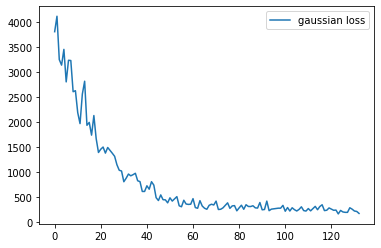

In [90]:
plt.plot(whole_gaussian_loss_list, label='gaussian loss')
plt.legend(loc="upper right");plt.show()

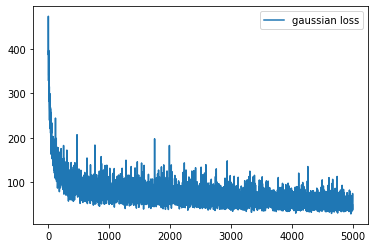

In [49]:
plt.plot(whole_gaussian_loss_list, label='gaussian loss')
plt.legend(loc="upper right");plt.show()

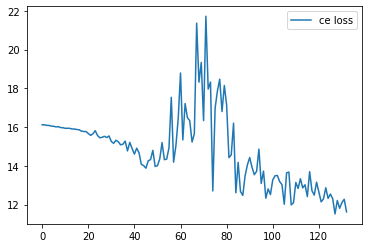

In [91]:
plt.plot(whole_ce_loss_list, label='ce loss')
plt.legend(loc="upper right");plt.show()

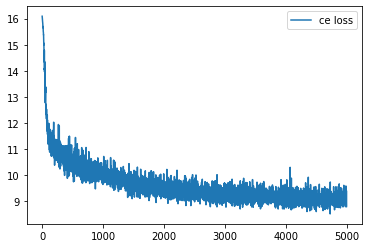

In [50]:
plt.plot(whole_ce_loss_list, label='ce loss')
plt.legend(loc="upper right");plt.show()

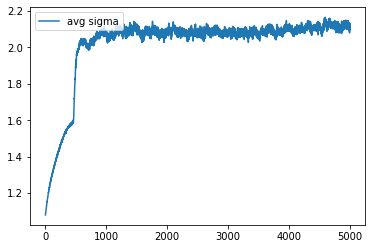

In [51]:
plt.plot(whole_sigma_list, label='avg sigma')
plt.legend(loc="upper left");plt.show()

In [24]:
def generate_batch_sequence_by_rollout(
        G, batch_size, T, end_token=0, init_token=1, max_time=1024, verbose=False):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    curr_state_et = np.zeros([batch_size, 1, 1])
    curr_state_et[:, 0, 0] = init_token

    curr_state_ts = np.zeros([batch_size, 1, 1])
    curr_state_ts[:, 0, 0] = 0.0
    
    all_state_et = curr_state_et
    all_state_ts = curr_state_ts

    G.reset_states()

    for step in range(1, T):  # sequence length
        token_prob, alpha, mu, sigma = G([curr_state_et, curr_state_ts])
        sampled_et = tf.random.categorical(tf.math.log(token_prob), num_samples=1, dtype=tf.int32)
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, 1])

        # stop genererating once hit end_token
        cond_end_token = tf.equal(curr_state_et, end_token)
        curr_state_et = tf.where(cond_end_token, curr_state_et, sampled_et)
        all_state_et = tf.concat([all_state_et, curr_state_et], axis=1)

        # generate one timstamp using [alpha, mu, sigma]
        gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(
                probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu,
                scale=sigma))

        sampled_ts = tf.clip_by_value(gm.sample(), clip_value_min=1, clip_value_max=max_time)
        sampled_ts = tf.reshape(sampled_ts, [batch_size, 1, 1])

        # stop genererating once hit end_token
        curr_state_ts = tf.where(cond_end_token, curr_state_ts, sampled_ts)
        all_state_ts = tf.concat([all_state_ts, curr_state_ts], axis=1)
    return all_state_et, all_state_ts

In [ ]:
def mc_rollout_reward(G, D, partial_state_et, partial_state_ts):
    curr_state_et = np.zeros([batch_size, 1, 1])
    curr_state_et[:, 0, 0] = init_token

    curr_state_ts = np.zeros([batch_size, 1, 1])
    curr_state_ts[:, 0, 0] = 0.0
    
    all_state_et = curr_state_et
    all_state_ts = curr_state_ts

    G.reset_states()

    for step in range(1, T):  # sequence length
        token_prob, alpha, mu, sigma = G([curr_state_et, curr_state_ts])
        sampled_et = tf.random.categorical(tf.math.log(token_prob), num_samples=1, dtype=tf.int32)
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, 1])

        # stop genererating once hit end_token
        cond_end_token = tf.equal(curr_state_et, end_token)
        curr_state_et = tf.where(cond_end_token, curr_state_et, sampled_et)
        all_state_et = tf.concat([all_state_et, curr_state_et], axis=1)

        # generate one timstamp using [alpha, mu, sigma]
        gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(
                probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu,
                scale=sigma))

        sampled_ts = tf.clip_by_value(gm.sample(), clip_value_min=1, clip_value_max=max_time)
        sampled_ts = tf.reshape(sampled_ts, [batch_size, 1, 1])

        # stop genererating once hit end_token
        curr_state_ts = tf.where(cond_end_token, curr_state_ts, sampled_ts)
        all_state_ts = tf.concat([all_state_ts, curr_state_ts], axis=1)
    return all_state_et, all_state_ts

In [64]:
batch_size = 8
init_token = 0

curr_state_et = np.zeros([batch_size, 1, 1])
curr_state_et[:, 0, 0] = init_token

curr_state_ts = np.zeros([batch_size, 1, 1])
curr_state_ts[:, 0, 0] = 0.0

all_state_et = curr_state_et
all_state_ts = curr_state_ts

curr_state_et

array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]]])

In [61]:
all_state_et, all_state_ts = generate_batch_sequence_by_rollout(G, batch_size=BATCH_SIZE, T=T)
print(tf.squeeze(all_state_et))
print(tf.squeeze(all_state_ts))

tf.Tensor(
[[1 2 3 3 3 3 4 4 3 4 4]
 [1 2 3 2 2 3 3 4 3 2 2]
 [1 2 3 4 3 3 3 3 3 4 3]
 [1 2 3 3 2 2 4 2 4 3 2]
 [1 2 3 4 3 3 3 3 2 4 3]
 [1 2 3 2 2 3 2 3 4 2 2]
 [1 2 3 2 4 3 3 2 2 4 2]
 [1 2 2 2 3 2 3 2 3 4 3]], shape=(8, 11), dtype=int32)
tf.Tensor(
[[ 0.          5.24926263  6.95387153 12.0758274  18.68257985 14.76920613
  15.44348054  5.88285811 18.1658163  19.52303088  4.24221541]
 [ 0.          4.52537525 17.8582698   5.5253639   7.65287707 18.09869942
  16.03076262 22.79140188 15.08187579  8.03853185 14.10323796]
 [ 0.          6.8146849  11.90809101 11.44892756  6.63153272  4.83573133
  18.93599117 11.07060069 17.06230114 13.48590407 16.38346419]
 [ 0.          5.76629436 10.22818986 13.98724878 12.07403986 23.69903426
   8.70319926 10.62469485  8.65831396 16.63237705 12.85308276]
 [ 0.          4.42089199 10.04771151  3.24778548  2.5454485   6.56151094
  11.48788609 12.71942068  4.4199012  16.34350527 12.02253172]
 [ 0.          6.19985595  5.96866588  9.16345761  6.57767693  

## Pretrain G

In [ ]:
x = range(len(pretrain_gen_ce_loss_history))
plt.figure(dpi=100)
plt.plot(x, pretrain_gen_ce_loss_history)
plt.title('Pre-training Generator Categorical Cross-Entropy Loss History')
plt.xlabel('Pre-training steps')

x = range(len(pretrain_gen_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, pretrain_gen_gaussian_loss_history)
plt.title('Pre-training Generator Gaussian Loss History')
plt.xlabel('training steps')

### predict using pretrained G on self-regression

In [ ]:
self_regression_et, self_regression_ts, self_target_token, _ = create_self_regression_data_batch(feature_sample)
print(self_target_token.squeeze())

curr_state_et = self_regression_et
curr_state_ts = self_regression_ts

pred_token_prob, gaussian_log, mask, alpha, mu, sigma = pretrained_generator.predict((curr_state_et, curr_state_ts))
pred_token_prob.shape
print(pred_token_prob.argmax(axis=1))

### Save Pretrained G

In [ ]:
if not os.path.exists('./gan_model_weights/pretrain_1000_gen_clip'):
    os.makedirs('./gan_model_weights/pretrain_1000_gen_clip')
    
G_save_path = './gan_model_weights/pretrain_1000_gen_clip/model.tf'
pretrained_generator.save_weights(G_save_path)

In [ ]:
reload_pretrained_gen = build_G(
    T = T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
    k_mixt = K_MIST,
    return_sequence=False,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)

In [ ]:
reload_pretrained_gen.summary()

## Pretrain D 

In [ ]:
pretrain_D_et = np.concatenate([valid_event_type_seqs, invalid_event_type_seqs], axis=0)
pretrain_D_ts = np.concatenate([valid_timestamp_seqs, invalid_timestamp_seqs], axis=0)

pretrain_D_labels = np.concatenate([np.ones((valid_event_type_seqs.shape[0], 1)), 
                                  np.zeros((invalid_event_type_seqs.shape[0], 1))
                                 ], axis=0)
pretrain_D_features = (pretrain_D_et, pretrain_D_ts)
N_pretrain_D = pretrain_D_ts.shape[0]

In [ ]:
WEIGHT_GAUSSIAN_LOSS = 1e-2
OPTIMIZER = Adam(lr=1e-3)

EPOCHS = 1
_TOTAL_STEPS = 1000

pretrain_D_dataset = create_dataset(pretrain_D_features,
                                  pretrain_D_labels,
                                  batch_size=BATCH_SIZE,
                                  epochs=1,
                                  buffer_size=N_pretrain_D)

pretrained_discriminator = build_D(
    T = T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
    k_mixt = K_MIST
)

In [ ]:
pretrain_disc_token_loss_history = []
pretrain_disc_gaussian_loss_history = []

step = 0

for features_batch, real_labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
        
    disc_token_loss, disc_gaussian_loss = pretrain_discriminator(features_batch, real_labels, pretrained_discriminator, verbose=False, 
                                                                 weight_gaussian_loss=WEIGHT_GAUSSIAN_LOSS, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())
    pretrain_disc_gaussian_loss_history.append(disc_gaussian_loss.numpy())

In [ ]:
x = range(len(pretrain_disc_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, pretrain_disc_token_loss_history)
plt.title('Pre-training Discriminator CE Loss History')
plt.xlabel('Pre-training steps')

x = range(len(pretrain_disc_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, pretrain_disc_gaussian_loss_history)
plt.title('Pre-training Discriminator Gaussian Loss History')
plt.xlabel('training steps')

### Save Pretrained D

In [ ]:
if not os.path.exists('./gan_model_weights/pretrain_1000_disc/'):
    os.makedirs('./gan_model_weights/pretrain_1000_disc/')
    
D_save_path = './gan_model_weights/pretrain_1000_disc/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [ ]:
reload_pretrained_disc = build_D(
    T = T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
    k_mixt = K_MIST
)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)

In [ ]:
reload_pretrained_disc.summary()

## Code chunk

In [ ]:
# import pickle
# import numpy as np
# import tensorflow as tf

# def load_fixed_length_sequence_from_pickle(pickle_file_path, to_timedelta=True, end_token=0):
#     """
#         A list of sequence in format of (event_type, timestamp)
#         [[(1, 11), (1, 24), (2, 37), (3, 47), (2, 63), (2, 80), (1, 88), (2, 95), (2, 104), (3, 111)], ...]
#     :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
#     :param to_timedelta: if True, convert absolute time to timedelta
#     :param end_token: same as padding token. default 0
#     :return: (event_type_seqs, timestamp_seqs)
#     """
#     with open(pickle_file_path, 'rb') as f:
#         raw_seqs = pickle.load(f)

#     if not raw_seqs or not raw_seqs[0]:
#         return np.array([]), np.array([])

#     N = len(raw_seqs)
#     T = len(raw_seqs[0])

#     event_type_seqs = []
#     timestamp_seqs = []

#     for seq in raw_seqs:
#         _ets, _tss = [], []
#         ts_prev = 0
#         for et, ts in seq:
#             if et == end_token:
#                 raise ValueError('Actual data should NOT contain END_TOKEN', end_token)
#             _ets.append(et)  # 0 is for padding, standing for END_TOKEN or 'N/A'
#             if to_timedelta:
#                 _tss.append(ts - ts_prev)
#                 ts_prev = ts
#             else:
#                 _tss.append(ts)
#         event_type_seqs.append(_ets)
#         timestamp_seqs.append(_tss)

#     event_type_seqs = np.array(event_type_seqs).astype(np.float64).reshape((N, T, 1))
#     timestamp_seqs = np.array(timestamp_seqs).astype(np.float64).reshape((N, T, 1))

#     return event_type_seqs, timestamp_seqs

In [ ]:
# def create_self_regression_data_batch(original_feature_sample, END_TOKEN=0):
#     """
#         Create self regression dataset given original sequences
#         only support batch_size = 1 for now, aka, we have to pretrain the generator one seq by

#         e.g. original event type seq (including init token -1): [-1, 1, 2, 3, 1, 1, 3]
#         turns into a train dataset with the next token(softmax)/timstamp as the target
        
#         [-1, 0, 0, 0, 0, 0, 0] -> 1 : [0, 1.0, 0, 0]
#         [-1, 1, 0, 0, 0, 0, 0] -> 2 : [0, 0, 1.0, 0]
#         [-1, 1, 2, 0, 0, 0, 0] -> 3 : [0, 0, 0, 1.0]
#         [-1, 1, 2, 3, 0, 0, 0] -> 1 : [0, 1.0, 0, 0]
#         [-1, 1, 2, 3, 1, 0, 0] -> 1 : [0, 1.0, 0, 0]
#         [-1, 1, 2, 3, 1, 1, 0] -> 3 : [0, 0, 0, 1.0]

#         same for timestamp sequence.

#     :param original_feature_sample: tuple of numpy arrays (seq_et, seq_ts), each of shape (1, T, 1)
#     :param END_TOKEN: by default 0. so that we can fill non-zero values in np.zeros
#     :return:
#     """
#     orig_seq_et, orig_seq_ts = original_feature_sample
#     _, T_orig, _ = orig_seq_et.shape

#     self_regression_et = np.zeros((T_orig - 1, T_orig, 1))
#     self_regression_ts = np.zeros((T_orig - 1, T_orig, 1))

#     self_target_token = np.zeros((T_orig - 1, 1))
#     self_target_timestamp = np.zeros((T_orig - 1, 1))

#     for i in range(T_orig - 1):
#         self_regression_et[i, :i + 1, :] = orig_seq_et[:, :i + 1, :]
#         self_regression_ts[i, :i + 1, :] = orig_seq_ts[:, :i + 1, :]

#         self_target_token[i, :] = orig_seq_et[:, i + 1, :]
#         self_target_timestamp[i, :] = orig_seq_ts[:, i + 1, :]

#     return self_regression_et, self_regression_ts, self_target_token, self_target_timestamp

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.optimizers import Adam, SGD

# def pretrain_generator(feature_sample, generator, event_vocab_dim, verbose=False, weight_gaussian_loss=1,
#                        optimizer=Adam(lr=0.001)):
#     self_regression_et, self_regression_ts, self_target_token, _ = create_self_regression_data_batch(feature_sample)
#     # self_target_timestamp is not actually needed here,
#     # because we cauculate log-likelihood of gaussian mixture fitting original input timestamps
#     # rather than comparing the next actual timestamp with a sampled timestamp from the updated gm distribution
#     N_reg = self_regression_et.shape[0]

#     ce_loss_list = []
#     gaussian_loss_list = []

#     # train the generator
#     with tf.GradientTape() as tape:
#         for i in range(N_reg):
#             curr_state_et = self_regression_et[[i], :, :]
#             curr_state_ts = self_regression_ts[[i], :, :]

#             curr_target_token = int(self_target_token[i].item())
#             curr_target_token_prob = np.zeros((event_vocab_dim,))
#             curr_target_token_prob[curr_target_token] = 1.0

#             pred_token_prob, gaussian_log, mask, alpha, mu, sigma = generator([curr_state_et, curr_state_ts])

#             gaussian_log = gaussian_log[0, 0:i + 1, 0]  # masked to the current step only
#             gaussian_loss = -tf.reduce_sum(gaussian_log)
#             ce_loss = tf.reduce_sum(tf.keras.losses.categorical_crossentropy(
#                 curr_target_token_prob, pred_token_prob, from_logits=False, label_smoothing=0))

#             ce_loss_list.append(ce_loss)
#             gaussian_loss_list.append(gaussian_loss)

#         ce_loss_batch = tf.reduce_mean(ce_loss_list)
#         gaussian_loss_batch = tf.reduce_mean(gaussian_loss_list)
#         pretrain_generator_loss_batch = ce_loss_batch + weight_gaussian_loss * gaussian_loss_batch

#         if verbose:
#             print('pretrain generator categorical cross-entropy loss:{}'.format(ce_loss_batch))
#             print('pretrain generator gaussian loss:{}'.format(gaussian_loss_batch))

#     # apply gradient decent per batch
#     grads = tape.gradient(pretrain_generator_loss_batch, generator.trainable_variables)
#     optimizer.apply_gradients(zip(grads, generator.trainable_variables))

#     return ce_loss_batch, gaussian_loss_batch


# def pretrain_discriminator(features_batch, real_labels, discriminator, verbose=False, weight_gaussian_loss=1,
#                            optimizer=Adam(lr=0.001)):
#     # train the discriminator
#     with tf.GradientTape() as tape:
#         real_et, real_ts = features_batch

#         # train discriminator
#         true_prob, gaussian_log, mask = discriminator((real_et, real_ts))

#         # calculate masked neg-likelihood of gaussian mixture
#         gaussian_log = gaussian_log[:, :, 0:1]
#         gaussian_log = tf.boolean_mask(gaussian_log, mask)
#         gaussian_loss = -tf.reduce_sum(gaussian_log)

#         # cross-entropy loss
#         ce_loss = tf.reduce_mean(
#             tf.keras.losses.binary_crossentropy(real_labels, true_prob, from_logits=False))
#         discriminator_loss = gaussian_loss * weight_gaussian_loss + ce_loss

#         if verbose:
#             print('discriminator token loss:{}'.format(ce_loss))
#             print('discriminator gaussian loss:{}'.format(gaussian_loss))
#             print('total discriminator loss:{}'.format(discriminator_loss))

#     grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
#     optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

#     return ce_loss, gaussian_loss

## Code chunk

In [8]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense
# import tensorflow_probability as tfp
# from tensorflow_probability import distributions as tfd

# from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

# tf.keras.backend.set_floatx('float64')


# def build_D(T, event_vocab_dim, emb_dim, hidden_dim=11, k_mixt=7):
#     """
#         Build a discriminator for event type sequence of shape (batch_size, T, input_dim)
#         and input event type sequence of shape (batch_size, T, 1)
#     :param T: length of the sequence
#     :param event_vocab_dim: size of event vocabulary ['na', 'start', 'click', 'install']
#     :param emb_dim: dimension of the embedding layer output for event type
#     :param hidden_dim: dimension hidden of the time lstm cell
#     :param k_mixt: num of gaussian distributions in gaussian mixture model
#     :return: discriminator D
#     """
#     # Time-LSTM:
#     i_et = Input(shape=(T, 1), name='event_type')  # input of discrete feature event type
#     i_ts = Input(shape=(T, 1), name='time_delta')  # input of continuous feature timestamp
#     mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(T, 1))
#     masked_ts = mask_layer(i_ts)

#     embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, input_length=T, mask_zero=True)(i_et)
#     embed0 = Reshape((T, emb_dim))(embed0)  # shape=[Batch_size, T, emb_dim]
#     merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2)  # # shape=[Batch_size, T, emb_dim + time_dim]

#     merged0 = tf.keras.layers.LayerNormalization()(merged0)
#     merged0 = tf.keras.layers.PReLU()(merged0)

#     hm, tm = TimeLSTM1(hidden_dim, activation='selu', name='time_lstm', return_sequences=False)(merged0)

#     # gaussian mixture for time delta
#     alpha = Dense(k_mixt, activation=tf.nn.softmax, name='dense_alpha')(tm)
#     mu = Dense(k_mixt, activation=None, name='dense_mu')(tm)
#     sigma = Dense(k_mixt, activation=tf.nn.softplus, name='dense_sigma')(tm)

#     gm = tfd.MixtureSameFamily(
#         mixture_distribution=tfd.Categorical(
#             probs=alpha),
#         components_distribution=tfd.Normal(
#             loc=mu,
#             scale=sigma))

#     gaussian_log = gm.log_prob(masked_ts)  # apply gaussian mixture to time stamp input

#     # mask out zeros in time stamps
#     mask = tf.not_equal(i_ts, 0)

#     # predicted real prob
#     real_prob = Dense(1, activation='sigmoid', name='fraud_prob')(hm)

#     discriminator = Model(
#         inputs=[i_et, i_ts],
#         outputs=[real_prob, gaussian_log, mask])

#     return discriminator


# def build_G(T, event_vocab_dim, emb_dim, hidden_dim=11, k_mixt=7, return_sequence=False):
#     """
#         Build a generator for event type sequence of shape (batch_size, T, input_dim)
#         and input event type sequence of shape (batch_size, T, 1)
#     :param T: length of the sequence
#     :param event_vocab_dim: size of event vocabulary ['na', 'start', 'click', 'install']
#     :param emb_dim: dimension of the embedding layer output for event type
#     :param hidden_dim: dimension hidden of the time lstm cell
#     :param k_mixt: num of gaussian distributions in gaussian mixture model
#     :param return_sequence:
#     :return:
#     """
#     # Time-LSTM:
#     i_et = Input(shape=(T, 1), name='event_type')  # input of discrete feature event type
#     i_ts = Input(shape=(T, 1), name='time_delta')  # input of continuous feature timestamp

#     mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(T, 1))
#     masked_ts = mask_layer(i_ts)

#     embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, input_length=T, mask_zero=True)(i_et)
#     embed0 = Reshape((T, emb_dim))(embed0)
#     merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2)

#     # TODO: add deep layers to lstm
#     # TODO: add activation after layer norm/batch norm
#     merged0 = tf.keras.layers.LayerNormalization()(merged0)
#     merged0 = tf.keras.layers.PReLU()(merged0)

#     hm, tm = TimeLSTM1(hidden_dim, activation='selu', name='time_lstm', return_sequences=False)(merged0)

#     # gaussian mixture for time delta
#     alpha = Dense(k_mixt, activation=tf.nn.softmax, name='dense_alpha')(tm)
#     mu = Dense(k_mixt, activation=None, name='dense_mu')(tm)
#     sigma = Dense(k_mixt, activation=tf.nn.softplus, name='dense_sigma')(tm)

#     # add regularization to sigma to avoid GM collapse
#     print('sigma > 1 !')
#     sigma = tf.clip_by_value(sigma, clip_value_min=1.0, clip_value_max=1024)

#     gm = tfd.MixtureSameFamily(
#         mixture_distribution=tfd.Categorical(
#             probs=alpha),
#         components_distribution=tfd.Normal(
#             loc=mu,
#             scale=sigma))

#     # mask out zeros in time stamps
#     mask = tf.not_equal(i_ts, 0)
#     gaussian_log = gm.log_prob(masked_ts)  # apply gaussian mixture to time stamp input

#     # predicted prob of next token
#     token_prob = Dense(event_vocab_dim, activation='softmax', name='token_prob')(hm)

#     model_gen = Model(
#         inputs=[i_et, i_ts],
#         outputs=[token_prob, gaussian_log, mask, alpha, mu, sigma])

#     return model_gen


## Debug 

In [ ]:
valid_event_type_seqs.shape

In [ ]:
for feature_sample, label_sample in pretrain_dataset.take(1):
    print('feature_sample =', feature_sample)
    print('label_sample =', label_sample)

In [ ]:
feature_sample[0].shape

In [ ]:
valid_event_type_seqs[0]